# Machine Learning - Practical 2

Names: {YOUR NAMES}

In [38]:
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

# Task 1: The Data

We use the mouse protein expression dataset: https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression
Please use the code provided below for loading the dataset.

In [39]:
file = 'Data_Cortex_Nuclear.csv'
df = pd.read_csv(file)

N = 10  # use only every tenth sample
X_all = df.iloc[::N,1:65].to_numpy()
t_all = (df['Behavior'] == 'S/C').to_numpy()[::N]

idx = ~np.any(np.isnan(X_all), axis=1)
X_all = X_all[idx]
t_all = t_all[idx]

### Tasks 1.1: Dataset Exploration 

Let's start with a bit of exploration.

- How many samples / features are provided?
- How many labels does the dataset have?
- What is the value range of the individuals predictors?
- Visualize the 10 first samples of the dataset in a form that highlights their differences.
- Visualize the variance of each predictor.

0          309_1
1          309_2
2          309_3
3          309_4
4          309_5
          ...   
1075    J3295_11
1076    J3295_12
1077    J3295_13
1078    J3295_14
1079    J3295_15
Name: MouseID, Length: 1080, dtype: object


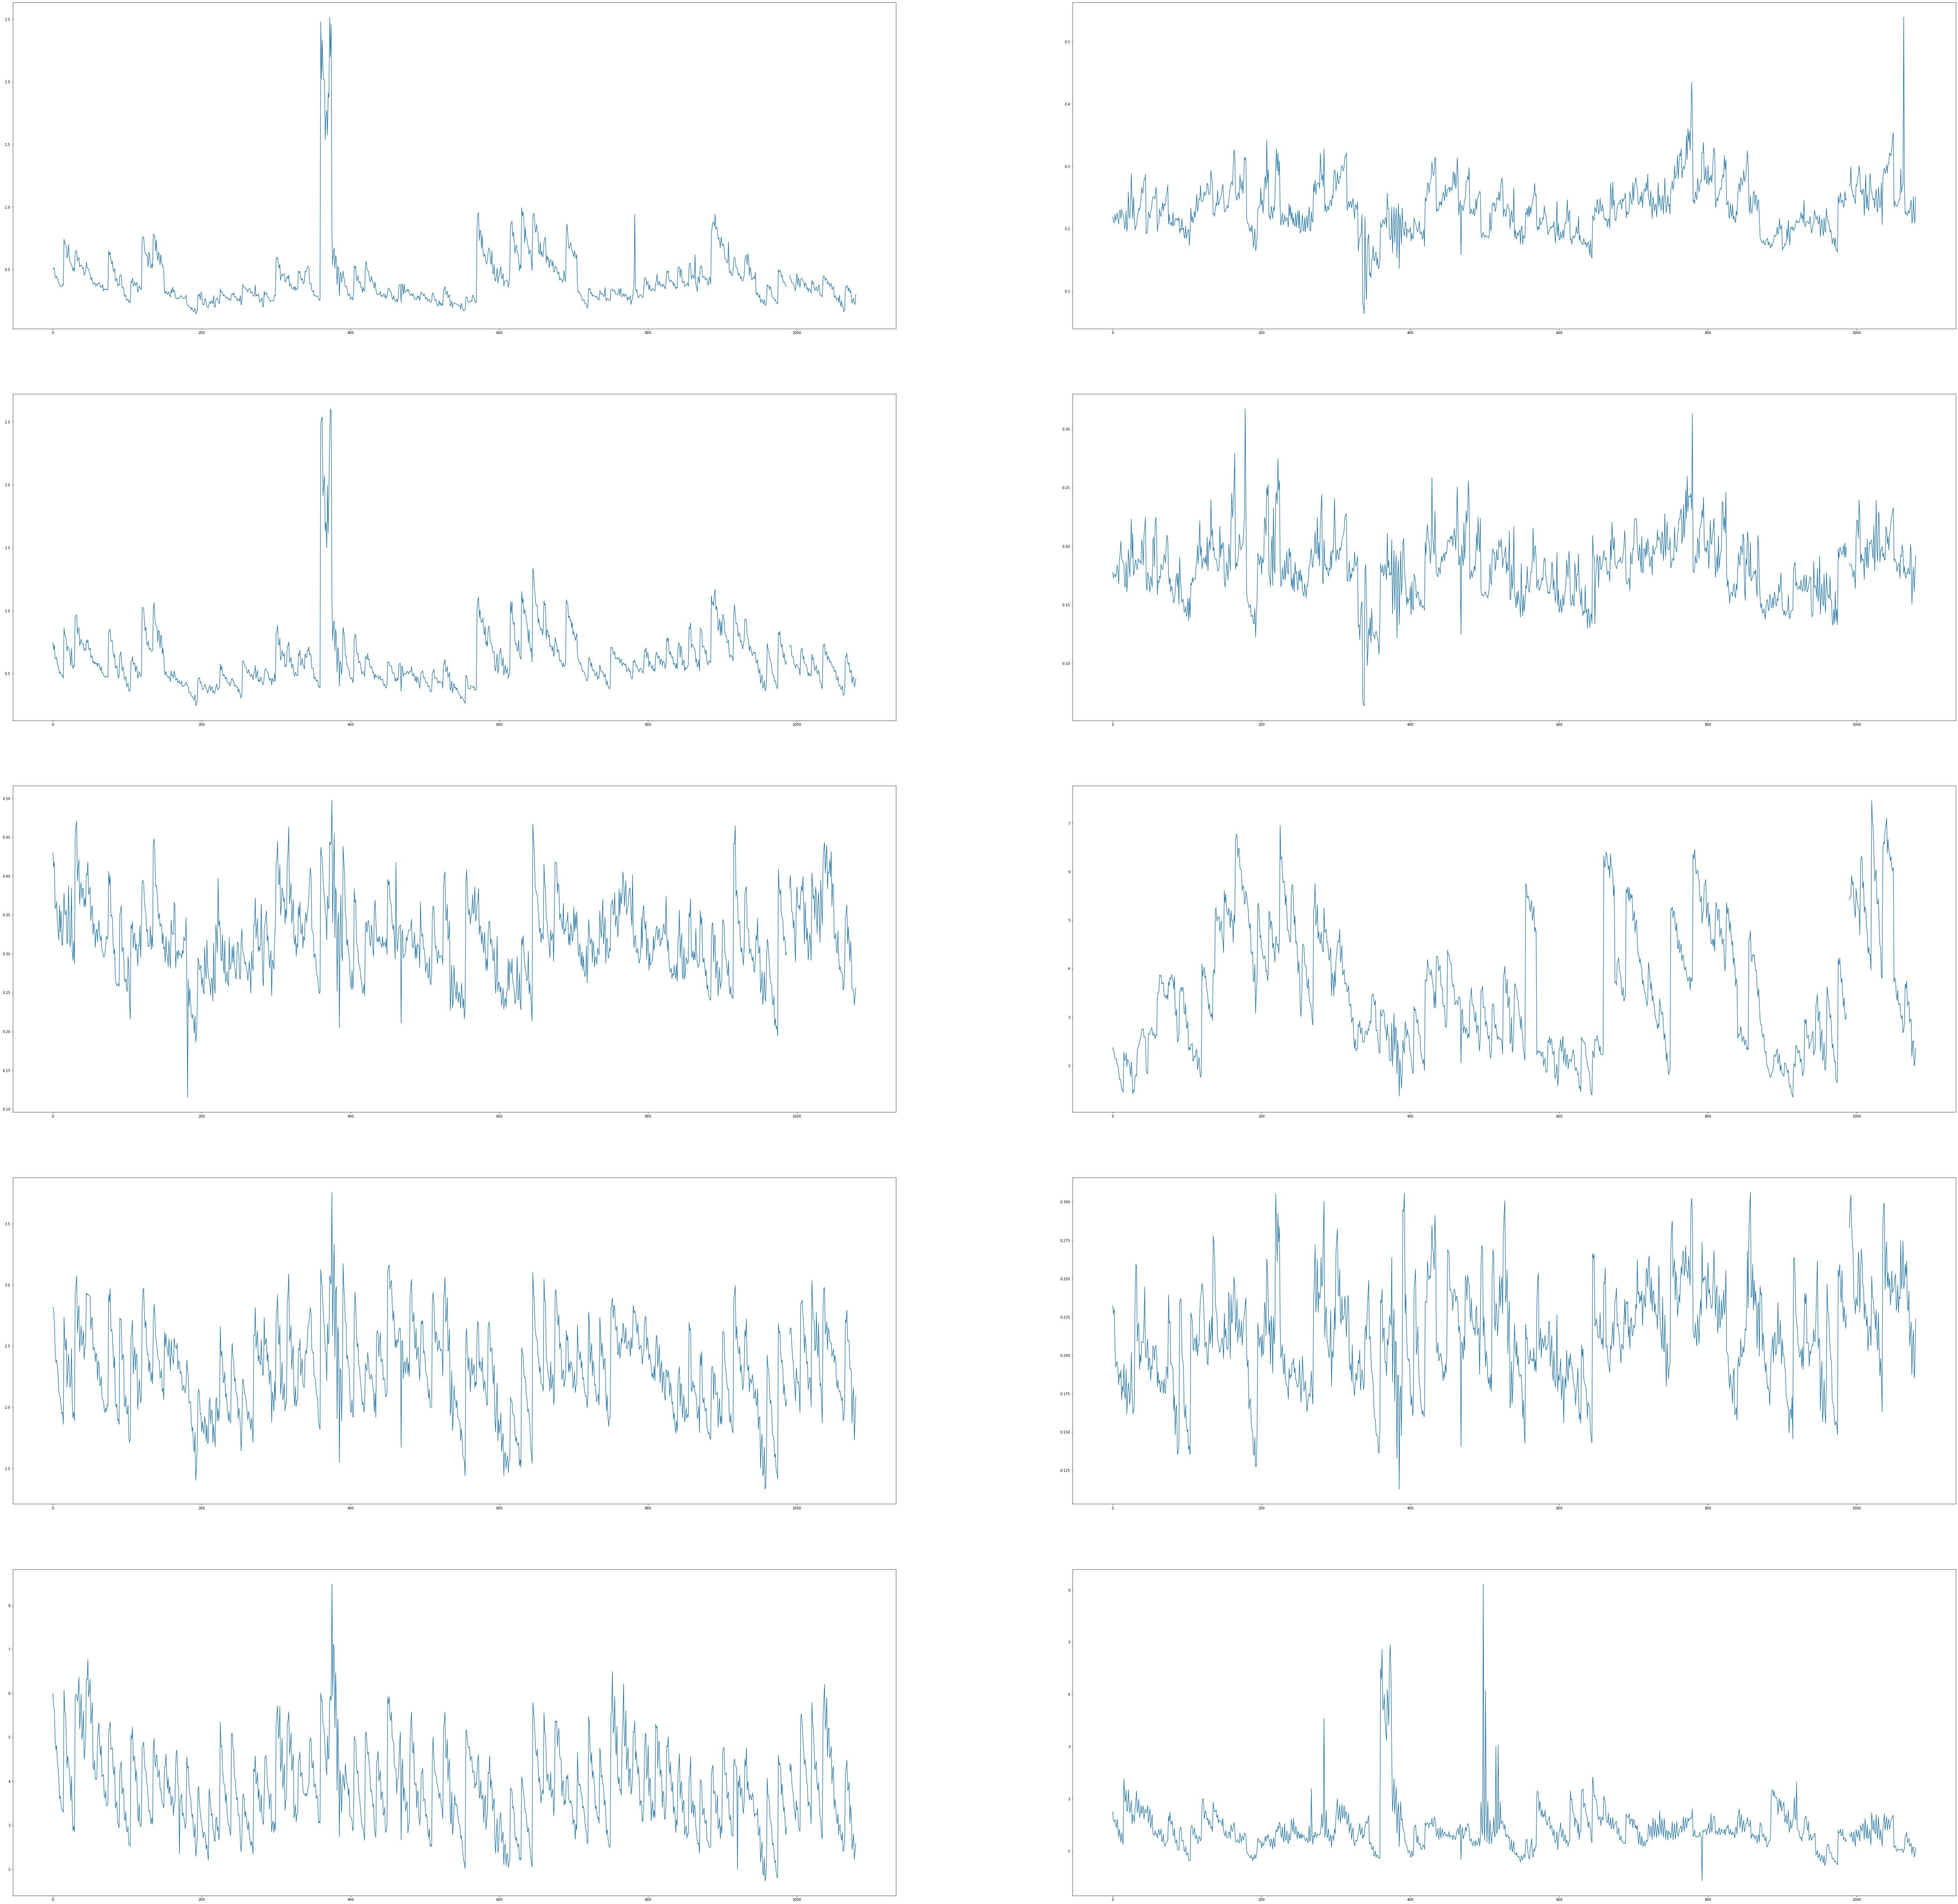

<function matplotlib.pyplot.show(close=None, block=None)>

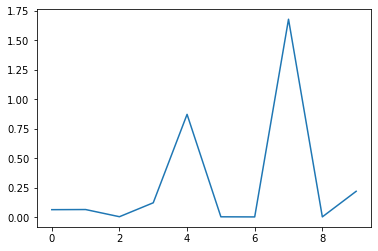

In [40]:
# data exploration
#print(df)

N=df.shape
M=df.columns
len(M)
value_range=[(i,min(df[i]),max(df[i])) for i in df.columns ]
print(df[df.columns[0]])

fig,ax=plt.subplots(5,2,figsize=(100,100))
for i in range(1,11):
        ax[(i-1)%5,int((i-1)/5)].plot(df[df.columns[i]])
plt.show()    


var=[np.var(df[i]) for i in df.columns[1:11]]
plt.plot(var)
plt.show

**Task 1.2: Data Preprocessing**:  
- Write a function `split_data(X, y, frac, seed)` that first shuffles your training data and then splits it into a training and a test set. `frac` determines the relative size of the test dataset, `seed` makes sure we get reproducible 
results.  
- Write a function `preprocess(X)` which zero-centers your data and sets variance to one (per-feature).

In [41]:
def split_data(X, y, frac=0.3, s=None):
    if s is not None:
        np.random.set_state(s)

    # ---------------- INSERT CODE ----------------------
    idx = X.shape[0]

    n_trainset = int(idx*(1-frac))  # size of the training set
    n_testset = idx-n_trainset  # size of the test set

    idx_shuffled = np.random.permutation(idx)

    test_idx = idx_shuffled[:n_testset]
    train_idx = idx_shuffled[n_testset:n_testset+n_trainset]

    X_test = X[test_idx]
    y_test = y[test_idx]
    print('Test set shapes (X and y)', X_test.shape, y_test.shape)

    X_train = X[train_idx]
    y_train = y[train_idx]
    print('Training set shapes (X and y):', X_train.shape, y_train.shape)
    

    # ---------------- END CODE -------------------------
    
    return X_train, X_test, y_train, y_test
    
    
def preprocess(X, verbose=False):
    # if seed is not None:
    #     np.random.seed(seed)

    # ---------------- INSERT CODE ----------------------
    mean_old = np.mean(X, axis=1)
    if verbose: print("Means: ", mean_old)
    X = np.subtract(X.transpose(),mean_old).transpose()
    variance_old = np.var(X, axis=1)
    if verbose: print("Variances: ", variance_old)
    X = (X.transpose()/(np.std(X,axis=1))).transpose()

    
    # ---------------- END CODE -------------------------
    
    return X

# Task 2: LDA

First, use Linear Discriminant Analysis to separate the classes. As discussed in the Bishop in pg. 186-189, we can find a weight vector $\vec{w}$ that performs a projection of the i-th input data point $\vec{x}_i$

$p =   \vec{w}^T \vec{x}_i$

that optimally separates the classes.

Use the analytic solution to compute the optimal weights $\vec{w}$ from the training set data. 

### Task 2.1

1. Implement a function `compute_lda_weights(x, y)` manually, which carries out LDA using the data `x,y`. 
2. Apply this function on your training data.
3. Visualize the obtained weight vector $\vec{w}$ using a `plt.stemplot`.

Text(0.5, 0, 'predictors')

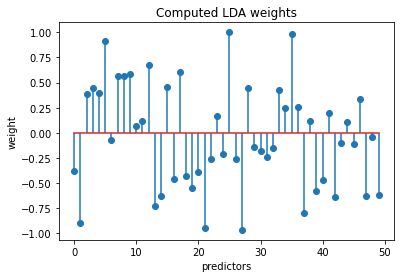

In [42]:
# example usage of stemplot
w_lda = np.random.uniform(-1, 1, 50)  # example data
plt.stem(w_lda.flatten(), use_line_collection=True)
plt.title('Computed LDA weights')
plt.ylabel('weight')
plt.xlabel('predictors')

In [43]:
def compute_lda_weights(x, y, alpha=0.001):
    '''function that computes regularized LDA weights for a two class problem

    input:
        x: training data -- array with shape (n_examples x n_features)
        y: training data class label -- flat array with length (n_examples)
        alpha: regularization strength -- float

    output:
        m0: mean of the training examples of class 0 -- flat array with length (n_features)
        m1: mean of the training examples of class 1 -- flat array with length (n_features)
        mdiff: difference of the two class means -- flat array with length (n_features)
        w: regularized LDA weight vector -- flat array with length (n_features)
        '''

    # ---------------- INSERT CODE ----------------------
    # Using Fishers linear discriminant 
    #create x0, x1
    x0 = np.array([x[i,:] for i in range(len(y)) if (y[i])])
    x1 = np.array([x[i,:] for i in range(len(y)) if (not y[i])])
    # Means
    m0 = np.mean(x0, axis=0)
    m1 = np.mean(x1, axis=0)
    mdiff = m0-m1
    # calculation of Sw
    Sw = np.cov(x0, rowvar=False)+np.cov(x1, rowvar=False)
    #calc weights
    w = np.linalg.inv(Sw) @ (m1-m0)
    # ---------------- END CODE -------------------------

    return m0, m1, mdiff, w

In [44]:
# split dataset and apply LDA
X_train, X_test, y_train, y_test = split_data(preprocess(X_all),t_all)
m0, m1 ,mdiff, w =  compute_lda_weights(X_train,y_train)
print("Shape of m0: " , m0.shape)
print("Shape of m1: " , m1.shape)
print("Shape of mdiff: " , mdiff.shape)
print("Shape of w: " , w.shape)

Test set shapes (X and y) (32, 64) (32,)
Training set shapes (X and y): (73, 64) (73,)
Shape of m0:  (64,)
Shape of m1:  (64,)
Shape of mdiff:  (64,)
Shape of w:  (64,)


Text(0.5, 0, 'predictors')

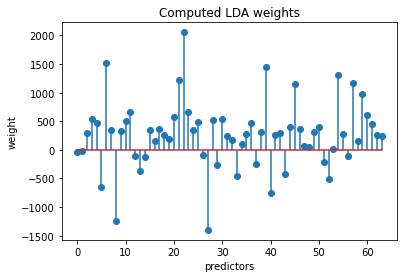

In [45]:
# visualize LDA weights using stemplot
plt.stem(w.flatten(), use_line_collection=True)
plt.title('Computed LDA weights')
plt.ylabel('weight')
plt.xlabel('predictors')

### Task 2.2

Project the training data and the test data on $\vec{w}$. Visualize the class separation using a two-color histogram. 
- Is the class separation good?
- Is there a big difference between training and test data?

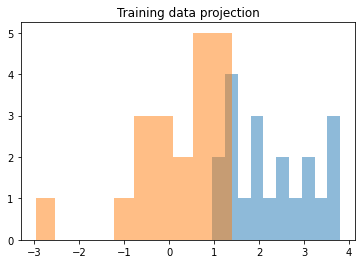

In [46]:
# example usage of histogram
a, b = np.random.normal(2, 1, 20), np.random.normal(0, 1, 20)  # example data

plt.title('Training data projection')
_ = plt.hist(a,label='class 0',alpha=0.5)
_ = plt.hist(b,label='class 1',alpha=0.5)

In [47]:
# compute projections for training and test data
p_train = w @ X_train.T
p_test = w @ X_test.T


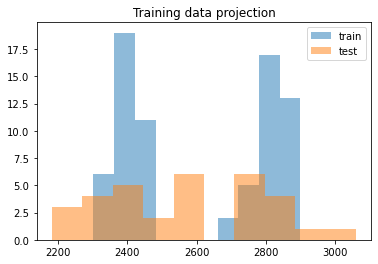

In [48]:
# visualize projections using histogram
plt.title('Training data projection')
_ = plt.hist(p_train,label='train',alpha=0.5)
_ = plt.hist(p_test,label='test',alpha=0.5)
plt.legend()
plt.show()

### Task 2.3

Now we make class predictions based on the projections. Read https://en.wikipedia.org/wiki/Linear_discriminant_analysis#Fisher's_linear_discriminant and compute threshold $c$ for the projected values $p$ based on the training data. Print the value of $c$ and plot $c$ into the histograms of projected values you made before!

Use $c$ to assign class labels for training and test set. Determine the classification errors (in terms of accuracy) on both datasets and print them. 

In [49]:
def compute_threshold_LDA(m0, m1, w):
    '''Compute the optimal threshold for LDA .

    input:
        m0, m1: mean vectors of the two classes -- flat array with length (n_features)
        w: weight vector of LDA -- flat array with length (n_features)

    output:
        c: the optimal threshold for LDA 
    '''

    # ---------------- INSERT CODE ----------------------
    c = w @ (1/2 * (m0+m1))
    # ---------------- END CODE -------------------------
  
    return c


def score_LDA(x_proj, y, c):
    '''Compute the accuracy given a threshold.

    input:
        x_proj: projected data -- flat array with length (n_examples)    
        y: class labels -- flat array with length (n_examples)
        c: optimal threshold for LDA - scalar

    output:
        y_hat: class label predicitons of LDA model -- flat array with length (n_examples)
        acc: classification accuracy
    '''
    # ---------------- INSERT CODE ----------------------
    y_hat = []
    acc = 0
    for xi,class_label in zip(x_proj,y):
        class_label_pred = xi>=c
        y_hat.append(class_label_pred)
        if class_label_pred != class_label:
            acc += 1
    acc /= len(x_proj) /100

    # ---------------- END CODE -------------------------
    
    return y_hat, acc

In [50]:
# compute optimal threshold
c_opt = compute_threshold_LDA(m0, m1, w)
print(c_opt)

2608.6488393511686


In [51]:
# compute classification accuracy
y_hat_train, acc_train = score_LDA(p_train, y_train, c_opt)
y_hat_test, acc_test = score_LDA(p_test, y_test, c_opt)

print(f"Acc for train: {acc_train} %, Acc for test: {acc_test} %")

Acc for train: 100.0 %, Acc for test: 93.75 %


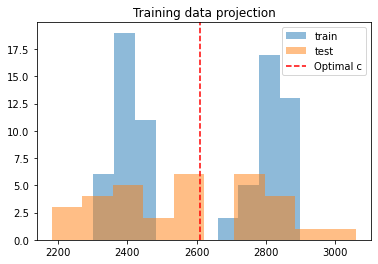

In [52]:
# visualize treshold in histogram
# visualize projections using histogram
plt.title('Training data projection')
_ = plt.hist(p_train,label='train',alpha=0.5)
_ = plt.hist(p_test,label='test',alpha=0.5)
#add vertical line at x=2
plt.axvline(x=c_opt, color='red', linestyle='--', label="Optimal c")
plt.legend()
plt.show()

## Task 3: Logistic Regression

Next, we will consider classification using Logistic Regression. 

For this task, we will use a different dataset:  
It consists of activations from a convolutional neural network (ResNet18) for images of cats and dogs.
The dataset contains 2,000 samples (i.e. CNN activations) and 256 features (i.e. the CNN activations have 256 dimensions). A target value of 0 indicates a cat, 1 a dog.

Below, you find all imports that are necessary.


In [53]:
X_all, t_all = pickle.load(open('cnn_features.pickle', 'rb'))

### Task 3.0: Normalize and split the data

Make sure the data has has zero mean and variance 1 per feature.

In [54]:
# normalize data
X_train, X_test, y_train, y_test = split_data(preprocess(X_all),t_all)

Test set shapes (X and y) (600, 256) (600,)
Training set shapes (X and y): (1400, 256) (1400,)


### Task 3.1: Iterative Reweighted Least Squares**

1. Implement the IRLS algorithm and output at each iteration the current training accuracy. Remember the weight are updated according to:
$$ w' = w - ( \Phi^T R \Phi ) ^ {-1} \Phi^T (y - t)$$
where $y$ is the prediction, $t$ the ground truth target, $R$ the weighting matrix and $\Phi$ the design matrix.  

    Hints:  
    (a) There is a bias term in logistic regression  
    (b) Use a small value for weight init to avoid numerical problems.


2. Apply the IRLS algorithm on data and compute the test accuracy.
3. Compare the results of your implementation to the sklearn implementation of `LogisticRegression(penalty='none')`. Do you get the same result?

In [55]:
# IRLS
def compute_irls_weights(X,t,change,seed=1, max_runs=100):

    # for reproducability
    np.random.seed = seed
    # Init
    y = np.random.uniform(size=X.shape[0])
    w = np.random.uniform(size=X.shape[1])
    ac_change = 1
    counter = 0
    try:
        while ac_change > change:
            R = np.diag(y * (1-y))
            w_old = np.sum(w)
            w = w - np.linalg.inv(X.T @ R @ X) @ X.T @ (y-t)
            w_new = np.sum(w)
            ac_change = abs(w_old-w_new)
            counter += 1
            if counter > max_runs:
                print(f"Returning after max runs of {max_runs}")
                return w
        print(f"Runned for {counter} times")
        return w
    except KeyboardInterrupt:
        print(f"Interrupted after: {counter} steps.")
        return w

In [56]:

w = compute_irls_weights(X_train, y_train, 0.001, max_runs=200)


Interrupted after: 143 steps.


In [ ]:
# compute projections for training and test data
p_train = (w @ X_train.T)
p_test = (w @ X_test.T)

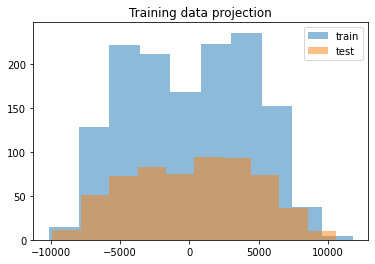

In [ ]:
# visualize projections using histogram
plt.title('Training data projection')
_ = plt.hist(p_train,label='train',alpha=0.5)
_ = plt.hist(p_test,label='test',alpha=0.5)
plt.legend()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='none').fit(X_train, y_train)
sk_p_train = clf.predict(X_train)
sk_p_test = clf.predict(X_test)

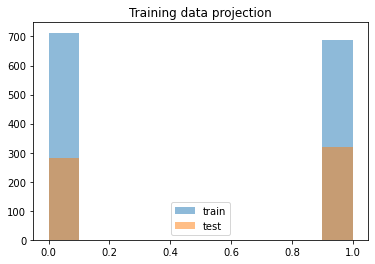

In [ ]:
# visualize projections using histogram
plt.title('Training data projection')
_ = plt.hist(sk_p_train,label='train',alpha=0.5)
_ = plt.hist(sk_p_test,label='test',alpha=0.5)
plt.legend()
plt.show()

### Task 3.2: Logistic Regression with Regularization

1. Set sklearn's penalty parameter to `l1` and `l2`. Use the range `np.linspace(0.02, 1, 25)` for the parameter `C`, which controls the strength of regularization. Where is the regularization strongest, for small or big `C`?   
Hint: For `l1` regularization you can use the `saga` solver.
2. Plot strength of regularization over accuracy. Does regularization improve the scores?
3. Visualize the coefficients (or just a subset of all coefficient for a better overview) of the regularized settings and the unregularized setting. What do you observe?
3. Compare the coefficients to the LDA weights.

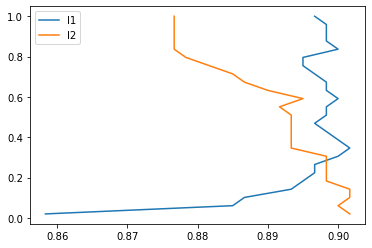

In [ ]:
%%capture --no-display
cs = np.linspace(0.02, 1, 25)
penalties = ['l1','l2']
for penalty in penalties:
    scores = []
    for c in cs:
        regressor  = LogisticRegression(penalty=penalty, C=c)
        if penalty == 'l1':
            regressor  = LogisticRegression(penalty=penalty, C=c, solver='saga')
        regressor.fit(X_train,y_train)
        scores.append(regressor.score(X_test,y_test))
    plt.plot(scores,cs, label=penalty)

plt.legend()
plt.show()

